<a href="https://colab.research.google.com/github/LorenaMueller/refine_DCG_outlines/blob/master/DCG_RF_timeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive

=== Processing year: 2016 ===

Overall Feature Importance (Across All Band Combinations):
slope: Mean = 0.3010, Median = 0.3033
lstNir_superPixelMeans: Mean = 0.1531, Median = 0.1574
ndri: Mean = 0.2142, Median = 0.2185
ndsi: Mean = 0.1428, Median = 0.1378
ndwi: Mean = 0.1198, Median = 0.1197
coherence: Mean = 0.1320, Median = 0.1345
ndvi: Mean = 0.1340, Median = 0.1373
VH: Mean = 0.1202, Median = 0.1209


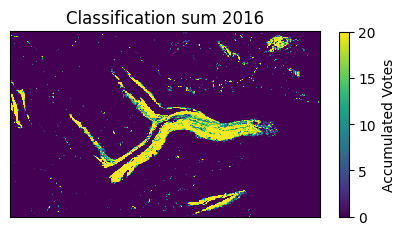

NameError: name 'smoothed_image_flat' is not defined

In [3]:
#Whole workflow without debugging steps

import os
import ee
import numpy as np
import pandas as pd
import rasterio
from rasterio.mask import mask
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report
from osgeo import gdal
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, label
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from skimage import measure
from matplotlib.patches import Patch


train_year = 2016  # Always using 2016 for training
train_glaciers = ['oberaletsch', 'zmutt']  # Glaciers used for training
test_glacier = 'unteraar'  # Glacier to test on
test_year = [2016, 2018, 2020, 2022] # Year to test on (can be modified)

# ==============================================================================
# Part I
# ==============================================================================

# Mount Google Drive (for Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Paths to images stored in Google Drive
glaciers = ['zmutt', 'unteraar', 'belvedere', 'oberaletsch']
years = [2016, 2018, 2020, 2022]

# Generate dynamic paths for all glaciers and years
image_paths = {}
for glacier in glaciers:
    image_paths[glacier] = {}
    for year in years:
        image_paths[glacier][year] = f"/content/drive/My Drive/GEE_Exports_input_layers_DCG/{glacier}_{year}_layers_drive.tif"


def read_raster(image_path):
    dataset = gdal.Open(image_path, gdal.GA_ReadOnly)
    if dataset is None:
        raise ValueError(f"Failed to open {image_path}. Check if the file exists and is readable.")
    image_array = dataset.ReadAsArray()
    return np.array(image_array)  # Ensure it's a NumPy array


# Load images directly from Google Drive
original_image_data = {}
for glacier in glaciers:
    original_image_data[glacier] = {}
    for year in years:
        original_image_data[glacier][year] = read_raster(image_paths[glacier][year])

# Assuming ground truth labels are stored separately, load them
labels_path = {
    "zmutt": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/zmutt_labels.tif",
    "unteraar": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/unteraar_labels.tif",
    "belvedere": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/belvedere_labels.tif",
    "oberaletsch": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/oberaletsch_labels.tif"
}

original_label_data = {}
for key, path in labels_path.items():
    with rasterio.open(path) as src:
        original_label_data[key] = src.read(1)  # Assuming single-band label

# Paths to shapefiles stored in Google Drive
buffers_paths = {
    "zmutt": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/rgi_buffer_zmutt.shp",
    "unteraar": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/rgi_buffer_unteraar.shp",
    "oberaletsch": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/rgi_buffer_oberaletsch.shp",
    "belvedere": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/rgi_buffer_belvedere.shp"
}

# Load shapefiles using geopandas
buffers = {key: gpd.read_file(path) for key, path in buffers_paths.items()}

# clip images with their corresponding buffer
import rasterio
from rasterio.mask import mask

# Function to clip a raster with its corresponding buffer
def clip_raster(raster_array, raster_path, buffer_gdf):
    with rasterio.open(raster_path) as src:
        # Reproject buffer to match raster CRS
        buffer_gdf = buffer_gdf.to_crs(src.crs)

        # Convert buffer to a list of geometries
        geometries = [geom for geom in buffer_gdf.geometry]

        # Clip the raster
        clipped_image, clipped_transform = mask(src, geometries, crop=True)

        # If it's a 3D array (bands, height, width), don't select [0] blindly
        if clipped_image.ndim == 3:  # Multi-band image
            clipped_image = np.moveaxis(clipped_image, 0, -1)  # Move bands to last axis
        elif clipped_image.ndim == 2:  # Single-band image
            clipped_image = clipped_image  # No change needed

        # Update metadata
        clipped_meta = src.meta.copy()
        clipped_meta.update({
            "height": clipped_image.shape[0],  # Update height
            "width": clipped_image.shape[1],   # Update width
            "transform": clipped_transform     # Update the transform
        })

    return clipped_image, clipped_meta  # Ensure clipped_image is a NumPy array

# Dictionaries to store clipped images and labels
image_data = {}
label_data = {}

for glacier in glaciers:
  image_data[glacier] = {}  # Initialize glacier-level dictionary
  label_data[glacier], _ = clip_raster(original_label_data[glacier], labels_path[glacier], buffers[glacier])


for glacier in glaciers:
  for year in years:
        # Clip the image
        image_data[glacier][year], _ = clip_raster(original_image_data[glacier][year], image_paths[glacier][year], buffers[glacier])

for glacier in glaciers:
    label_data[glacier] = {}  # Initialize dictionary for years
    for year in years:
        label_data[glacier][year], _ = clip_raster(original_label_data[glacier], labels_path[glacier], buffers[glacier])

# Only using the specified bands for training and testing
selected_bands = ['lstNir', 'ndri', 'lstNir_superPixelMeans', 'edges', 'smooth', 'ndwi', 'ndsi', 'ndvi', 'slope', 'aspect', 'elevation', 'gradient', 'TPI', 'glacierInventory', 'inSAR', 'normalizedLst', 'coherence', 'VH']
bands = selected_bands

# Mapping band names to indices in the images (these should match the band order in the images)
band_indices = {
    'lstNir': 0,
    'ndri': 1,
    'lstNir_superPixelMeans': 2,
    'edges': 3,
    'smooth': 4,
    'ndwi': 5,
    'ndsi': 6,
    'ndvi': 7,
    'slope': 8,
    'aspect': 9,
    'elevation': 10,
    'gradient': 11,
    'TPI': 12,
    'glacierInventory': 13,
    'inSAR': 14,
    'normalizedLst': 15,
    'coherence': 16,
    'VH': 17
}

# Prepare training and testing data
X_train, y_train, X_test, y_test = [], [], [], []

for glacier in train_glaciers:
    mask = ~np.isnan(label_data[glacier][train_year].squeeze())  # Mask for each glacier/year
    selected_data = image_data[glacier][train_year][:, :, list(band_indices.values())]  # Select the relevant bands
    X_train.append(selected_data[mask].reshape(-1, selected_data.shape[2]))  # Reshape to match the classifier input
    y_train.append(label_data[glacier][train_year].squeeze()[mask].ravel())  # Flatten the labels

X_train = np.vstack(X_train)
y_train = np.hstack(y_train)

# # Collect testing samples
# mask = (~np.isnan(label_data[test_glacier][year])).squeeze()
# X_test = image_data[test_glacier][year][:, :, list(band_indices.values())]
# X_test = X_test[mask].reshape(-1, len(band_indices))
# y_test = label_data[test_glacier][year].squeeze()[mask].ravel()

ensemble_results = {}
smoothed_images = {}
smoothed_images_flat = {}
accuracies_by_year = {}
reports_by_year = {}

for year in test_year:
    print(f"\n=== Processing year: {year} ===")

    # === (1) Generate X_test and y_test for this year ===
    mask = (~np.isnan(label_data[test_glacier][year])).squeeze()
    X_test = image_data[test_glacier][year][:, :, list(band_indices.values())]
    X_test = X_test[mask].reshape(-1, len(band_indices))
    y_test = label_data[test_glacier][year].squeeze()[mask].ravel()

    from sklearn.model_selection import StratifiedShuffleSplit

    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    for train_idx, _ in sss.split(X_train, y_train):
      X_train_balanced, y_train_balanced = X_train[train_idx], y_train[train_idx]

    # Check the class distribution in the training set before oversampling
    unique, counts = np.unique(y_train, return_counts=True)
    class_distribution = dict(zip(unique, counts))

    # Similarly for the balanced training data
    unique_balanced, counts_balanced = np.unique(y_train_balanced, return_counts=True)
    class_distribution_balanced = dict(zip(unique_balanced, counts_balanced))

    # Define all band combinations (20 random sets of 5 to 8 bands)
    band_combinations = [
        ['slope', 'lstNir_superPixelMeans', 'ndri', 'ndsi', 'ndwi', 'coherence', 'ndvi', 'VH'],
        ['slope', 'lstNir_superPixelMeans', 'ndri', 'ndsi', 'ndwi', 'coherence', 'ndvi'],
        ['slope', 'lstNir_superPixelMeans', 'ndri', 'ndsi', 'ndwi', 'coherence'],
        ['slope', 'lstNir_superPixelMeans', 'ndri', 'ndsi', 'ndvi', 'VH'],
        ['slope', 'lstNir_superPixelMeans', 'ndri', 'ndsi', 'coherence'],
        ['slope', 'lstNir_superPixelMeans', 'ndri', 'ndwi', 'coherence', 'ndvi'],
        ['slope', 'lstNir_superPixelMeans', 'ndri', 'ndsi', 'VH'],
        ['slope', 'lstNir_superPixelMeans', 'ndri', 'ndwi', 'coherence'],
        ['slope', 'lstNir_superPixelMeans', 'ndsi', 'ndwi', 'coherence', 'VH'],
        ['slope', 'lstNir_superPixelMeans', 'ndri', 'ndwi', 'coherence'],
        ['slope', 'lstNir_superPixelMeans', 'ndri', 'ndsi', 'ndwi'],
        ['slope', 'lstNir_superPixelMeans', 'ndsi', 'ndwi', 'coherence'],
        ['slope', 'lstNir_superPixelMeans', 'ndri', 'ndsi', 'coherence', 'VH'],
        ['slope', 'lstNir_superPixelMeans', 'ndri', 'ndsi', 'ndvi'],
        ['slope', 'lstNir_superPixelMeans', 'ndri', 'ndsi', 'VH'],
        ['slope', 'lstNir_superPixelMeans', 'ndri', 'ndwi', 'ndvi'],
        ['slope', 'lstNir_superPixelMeans', 'ndri', 'coherence', 'ndvi'],
        ['slope', 'lstNir_superPixelMeans', 'ndri', 'ndsi', 'ndwi'],
        ['slope', 'lstNir_superPixelMeans', 'ndri', 'ndsi', 'ndwi', 'VH'],
        ['slope', 'lstNir_superPixelMeans', 'ndri', 'ndsi', 'coherence', 'ndwi']
        ];

    # Initialize an array to store classification results
    ensemble_result = np.zeros_like(label_data[test_glacier], dtype=int)
    #ensemble_result = np.zeros(mask.shape, dtype=int)
    ensemble_results[year] = ensemble_result.copy()
# ==============================================================================
# Part II
# ==============================================================================

    from collections import defaultdict
    import numpy as np
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score

    # Dictionary to store feature importances for each band
    feature_importance_dict = defaultdict(list)

    # Store accuracies for each band combination
    accuracies = []

    # Ensure ensemble_result has the correct shape (matching mask)
    ensemble_result = np.zeros(mask.shape, dtype=int)  # Correct shape to match the mask

    # Run RF for each band combination and accumulate votes
    for bands in band_combinations:
        #print(f"Processing bands: {bands}")

        # Select valid band indices within X_train_balanced
        band_indices_selected = [
            band_indices[b] for b in bands if band_indices[b] < X_train_balanced.shape[1]
        ]

        if not band_indices_selected:
            print(f"Skipping bands {bands} as none were valid.")
            continue  # Skip invalid combinations

        # Extract selected bands for training and testing
        X_train_selected = X_train_balanced[:, band_indices_selected]
        X_test_selected = X_test[:, band_indices_selected]

        # Train Random Forest Classifier
        clf = RandomForestClassifier(n_estimators=100, random_state=42, max_samples=10000)
        clf.fit(X_train_selected, y_train_balanced)

        # Predict labels
        y_pred = clf.predict(X_test_selected).ravel()  # Ensure it's a flat array

        # Compute accuracy for this band combination
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

        # Ensure y_pred corresponds to the number of valid pixels in the mask
        if y_pred.shape[0] != np.sum(mask):
            continue

        # Apply y_pred values to the ensemble_result using the mask indices
        ensemble_result[mask] += y_pred.astype(int)  # Accumulate predictions where mask is True

        # Store feature importances
        feature_importances = clf.feature_importances_
        for band, importance in zip(bands, feature_importances):
            feature_importance_dict[band].append(importance)

    # Compute mean & median for each band
    overall_importance = {
        band: {
            "mean": np.mean(importances),
            "median": np.median(importances)
        }
        for band, importances in feature_importance_dict.items()
    }

    # ==============================================================================
    # Part III
    # ==============================================================================

    # Print results
    print("\nOverall Feature Importance (Across All Band Combinations):")
    for band, stats in overall_importance.items():
        print(f"{band}: Mean = {stats['mean']:.4f}, Median = {stats['median']:.4f}")

    # Plot Intermediate Classification Result (before thresholding)
    fig, ax = plt.subplots(figsize=(5, 4))
    im = ax.imshow(ensemble_result, interpolation='nearest', cmap="viridis")  # Using 'viridis' for better visualization

    # Remove axis labels and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Add colorbar to show accumulated votes
    cbar = plt.colorbar(im, ax=ax, shrink=0.6)
    cbar.set_label("Accumulated Votes")

    plt.title(f"Classification sum {year}")
    plt.show()

    # Compute threshold (90th percentile - 1)
    from skimage.filters import threshold_otsu

    threshold = threshold_otsu(ensemble_result[mask])  # Ensure it's on the masked values
    binary_classification = (ensemble_result >= threshold).astype(int)

    # Apply Gaussian Smoothing
    smoothed_image = gaussian_filter(binary_classification.astype(float), sigma=1)
    smoothed_image = np.round(smoothed_image)

    smoothed_images[year] = smoothed_image_flat.copy()

    # Calculate accuracy of the final classification result
    # Ensure smoothed_image matches the shape of the original mask
    smoothed_image_flat = smoothed_image[mask].ravel()
    smoothed_images_flat[year] = smoothed_image.copy()


    # Compare the smoothed classification result with the ground truth labels
    #y_true = label_data[test_region].squeeze()[mask].ravel()  # Flatten ground truth labels
    y_true = label_data[test_glacier][year].squeeze()[mask].ravel()

    # Compute accuracy
    accuracy = accuracy_score(y_true, smoothed_image_flat)
    accuracies_by_year[year] = accuracy
    print(f"Final Accuracy (after thresholding and smoothing) {year}: {accuracy:.4f}")

    # Print classification report for final classification
    report = classification_report(y_true, smoothed_image_flat)
    reports_by_year[year] = report
    print(f"Classification Report for final result {year}:")
    print(report)


    # Plot Smoothed Classification Result
    fig, ax = plt.subplots(figsize=(5, 4))
    im = ax.imshow(smoothed_image, interpolation='nearest', cmap="binary")

    # Remove axis labels and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Correcting label_data shape by squeezing out any extra dimensions
    label_2d = label_data[test_glacier][year].squeeze()

    # Overlay ground truth labels as contours
    contours = measure.find_contours(label_2d, level=0.5)
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color="red", label="SGI2016 Outline")

    # Add Legend
    legend_elements = [
        Patch(facecolor="black", edgecolor="black", label="Classified Region"),
        Patch(facecolor="white", edgecolor="red", label="SGI2016 outline")
    ]
    ax.legend(handles=legend_elements, loc="lower left", fontsize=10)

    # Add Scale Bar (1 pixel = 30 m --> 30 * 33.3 ~ 1km)
    scalebar_length = 33.3
    scalebar_x = smoothed_image.shape[1] * 0.90  # Position: 90% from left
    scalebar_y = smoothed_image.shape[0] * 0.95  # Position: 95% from top
    ax.plot([scalebar_x, scalebar_x + scalebar_length], [scalebar_y, scalebar_y],
            color='black', linewidth=3)
    ax.text(scalebar_x + scalebar_length / 2, scalebar_y - 5, "1 km", ha="center", fontsize=10, color="black")

    # Add North Arrow
    north_x = smoothed_image.shape[1] * 0.95
    north_y = smoothed_image.shape[0] * 0.05
    ax.annotate("N", xy=(north_x, north_y), xytext=(north_x, north_y + 30),
                arrowprops=dict(facecolor="black", width=3, headwidth=8),
                fontsize=12, color="black", ha="center")

    plt.title(f"Smoothed Classification Result {year}")
    plt.show()

    for year in years:
        print(f"Processing year: {year}")  # Debugging statement

for year in test_year:
    print(f"\n==== Summary for Year: {year} ====")
    print(f"Accuracy: {accuracies_by_year[year]:.4f}")
    print("Classification Report:")
    print(reports_by_year[year])

for year in test_year:
    plt.figure(figsize=(5, 4))
    plt.imshow(smoothed_images[year], cmap="binary")
    plt.title(f"Smoothed Classification {year}")
    plt.axis("off")
    plt.show()